In [107]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect
import random


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the dataset

In [183]:
cov = np.array([[0.4,0.3],[0.3,1.3]])
mean = [0,0]
scaling_factor = np.array([0.05,0.5])
number_cluster = 10
number_cluster_members = 20

In [184]:
random_stars = np.random.multivariate_normal(mean,cov,size=2000)

In [185]:
eigenvalues,eigenvectors = np.linalg.eig(cov)
eigenvalues_matrix = np.diag(eigenvalues)


In [186]:
eigenvalues_cluster = np.multiply(eigenvalues,scaling_factor)
eigenvalues_cluster_matrix = np.diag(eigenvalues_cluster)


In [187]:
cov_intracluster = np.dot(np.dot(eigenvectors,eigenvalues_cluster_matrix),np.linalg.inv(eigenvectors))

In [188]:
cov_intercluster = cov-cov_intracluster

In [189]:
#z_centered_cluster = np.random.multivariate_normal(mean,cov_intracluster,size=5000)

In [190]:
#plt.scatter(z[:,0],z[:,1],color="b",alpha=0.5,s=0.5)
#plt.scatter(z_centered_cluster[:,0],z_centered_cluster[:,1],color="g",alpha=0.5,s=0.5)

Text(0.5, 1.0, 'center of each cluster')

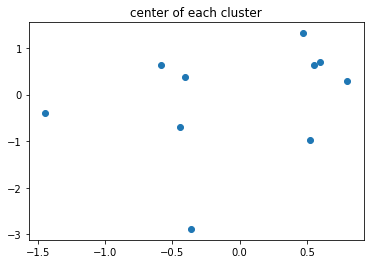

In [191]:
cluster_centers = np.random.multivariate_normal(mean,cov_intercluster,size=number_cluster)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1])
plt.title("center of each cluster")

In [192]:
cluster_stars = []
cluster_names = []
for i,cluster_center in enumerate(cluster_centers):
    cluster_members = cluster_center + np.random.multivariate_normal(mean,cov_intracluster,size=number_cluster_members)
    cluster_stars.append(cluster_members)
    cluster_names.append(np.array([str(i)]*number_cluster_members))
cluser_stars = np.array(cluster_stars)
cluster_names = np.array(cluster_names)

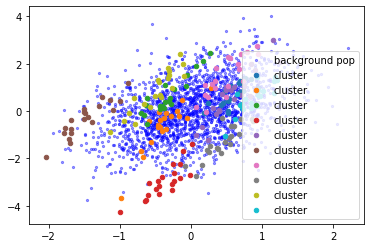

In [193]:
plt.scatter(random_stars[:,0],random_stars[:,1],color="b",alpha=0.4,s=5,label="background pop")
for star_cluster in cluser_stars:
    plt.scatter(star_cluster[:,0],star_cluster[:,1],alpha=1,s=20,label="cluster")
plt.legend()
#stars.reshape(-1,2)

(-1.8, 2)

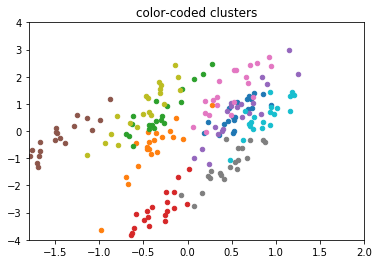

In [194]:
for star_cluster in cluser_stars:
    plt.scatter(star_cluster[:,0],star_cluster[:,1],alpha=1,s=20)
plt.title("color-coded clusters")
#plt.legend()
plt.ylim(-4,4)
plt.xlim(-1.8,2)

### Create visualisations

In [195]:
z = vector.Vector(random_stars.reshape(-1,2))
z_occam = vector.OccamLatentVector(cluster_names.reshape(-1),raw=cluser_stars.reshape(-1,2))


In [200]:
fitter = vector.Fitter(z,z_occam)

(-4, 4)

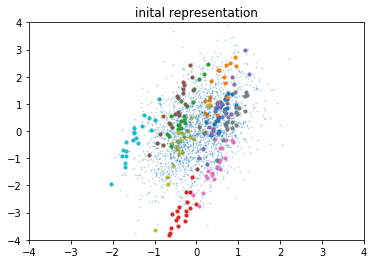

In [225]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z()[:,0],z()[:,1],s=1,alpha=0.2)
plt.title("inital representation")
plt.ylim(-4,4)
plt.xlim(-4,4)

(-4, 4)

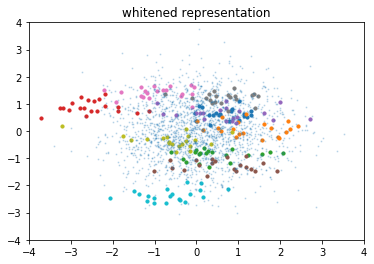

In [226]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.whitened(fitter.whitener).only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z.whitened(fitter.whitener)()[:,0],z.whitened(fitter.whitener)()[:,1],s=1,alpha=0.2)
plt.title("whitened representation")
plt.ylim(-4,4)
plt.xlim(-4,4)


(-4, 4)

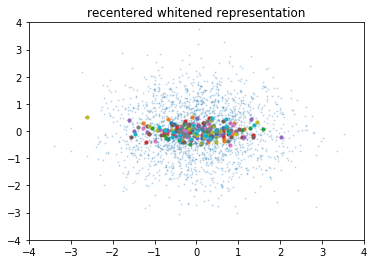

In [227]:
for cluster_name in list(z_occam.registry.keys()):
    members = z_occam.whitened(fitter.whitener).only(cluster_name).centered()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(z.whitened(fitter.whitener)()[:,0],z.whitened(fitter.whitener)()[:,1],s=1,alpha=0.2)
plt.title("recentered whitened representation")
plt.ylim(-4,4)
plt.xlim(-4,4)

In [231]:
v_occam =  vector.OccamLatentVector(cluster_names.reshape(-1),raw=fitter.transform(z_occam.centered))
v = vector.Vector(fitter.transform(z.centered))


Distances now encode chemical similarity

(-10, 10)

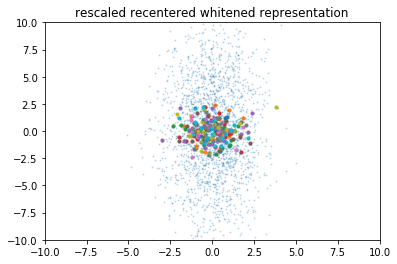

In [237]:
for cluster_name in list(v_occam.registry.keys()):
    members = v_occam.only(cluster_name).centered()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(v()[:,0],v()[:,1],s=1,alpha=0.2)
plt.title("rescaled recentered whitened representation")
plt.ylim(-10,10)
plt.xlim(-10,10)

(-10, 10)

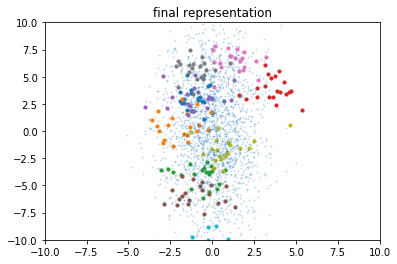

In [232]:
for cluster_name in list(v_occam.registry.keys()):
    members = v_occam.only(cluster_name)()
    plt.scatter(members[:,0],members[:,1],s=10)
plt.scatter(v()[:,0],v()[:,1],s=1,alpha=0.2)
plt.title("final representation")
plt.ylim(-10,10)
plt.xlim(-10,10)

In [205]:
print(inspect.getsource(vector.Fitter))

class Fitter():
    def __init__(self,z:Vector,z_occam:OccamLatentVector):
        self.z = z
        self.z_occam = z_occam
        self.whitener = PCA(n_components=self.z.raw.shape[1],whiten=True)
        self.pca = PCA(n_components=self.z.raw.shape[1])        
        #make z look like a unit gaussian
        self.whitener.fit(self.z.centered())
        #pick-up on directions of z_occam which are the most squashed relative to z
        self.pca.fit(self.z_occam.cluster_centered.whitened(self.whitener)())
        
        #self.scaling_factor = 1 #required to set to 1 because self.transform needs scaling factor
        self.scaling_factor = np.std(self.transform(self.z_occam.cluster_centered,scaling=False),axis=0)[None,:]
        
        
        
    def transform(self,vector,scaling=True):
        """transform a vector in a way that unit vector has variance one"""
        transformed_vector  = np.dot(vector.whitened(self.whitener)(),self.pca.components_.T)
        if scaling is Tr

In [208]:
print(inspect.getsource(vector.Vector))

class Vector():
    def __init__(self, raw, order=1,interaction_only=True):
        self._raw = raw
        if order>1:
            poly = PolynomialFeatures(order,interaction_only,include_bias=False)
            self._raw = poly.fit_transform(self._raw)

    def __call__(self):
        return self._raw

    def whitened(self,whitener):
        """method that takes a whitening PCA instance and returned a whitened vector"""
        return Vector(whitener.transform(self._raw))
        
    @property
    def raw(self):
        return self._raw
    
    @property
    def centered(self):
        return Vector(self._raw -np.mean(self._raw,axis=0))
    
    @property
    def normalized(self):
        return Vector(self.centered()/np.max(np.abs(self.centered()),0))



In [215]:
z_occam.whitened(fitter.whitener)

In [229]:
print(inspect.getsource(vector.Fitter))

class Fitter():
    def __init__(self,z:Vector,z_occam:OccamLatentVector):
        self.z = z
        self.z_occam = z_occam
        self.whitener = PCA(n_components=self.z.raw.shape[1],whiten=True)
        self.pca = PCA(n_components=self.z.raw.shape[1])        
        #make z look like a unit gaussian
        self.whitener.fit(self.z.centered())
        #pick-up on directions of z_occam which are the most squashed relative to z
        self.pca.fit(self.z_occam.cluster_centered.whitened(self.whitener)())
        
        #self.scaling_factor = 1 #required to set to 1 because self.transform needs scaling factor
        self.scaling_factor = np.std(self.transform(self.z_occam.cluster_centered,scaling=False),axis=0)[None,:]
        
        
        
    def transform(self,vector,scaling=True):
        """transform a vector in a way that unit vector has variance one"""
        transformed_vector  = np.dot(vector.whitened(self.whitener)(),self.pca.components_.T)
        if scaling is Tr